[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frhack/oli_ai/blob/main/notebooks/oli_ai_mnist_cosine_similarity.ipynb)

# MNIST - Riconoscimento di cifre con il metodo della similarità coseno

Questo notebook mostra come riconoscere cifre scritte a mano usando un semplice metodo basato sulla similarità coseno. Utilizzeremo il famoso dataset MNIST che contiene 70.000 immagini di cifre scritte a mano (da 0 a 9).

## Formato delle immagini digitali

Nel dataset MNIST, ogni immagine è rappresentata come una matrice di 28×28 pixel (totale 784 pixel). Ogni pixel contiene un valore numerico che rappresenta l'intensità di grigio:
- 0 rappresenta il bianco
- 255 rappresenta il nero
- I valori intermedi sono diverse tonalità di grigio

Quando elaboriamo queste immagini, possiamo:
1. Lavorare con la matrice 28×28 (utile per visualizzazione)
2. "Appiattire" l'immagine in un vettore di 784 elementi (utile per calcoli matematici)

## Train set e Test set: Perché dividiamo i dati?

Nel machine learning, dividiamo sempre i dati in almeno due gruppi:
- **Train set (dati di addestramento)**: Usato per insegnare al modello. Nel nostro caso, useremo questi dati per calcolare le immagini medie di ogni cifra.
- **Test set (dati di test)**: Usato per valutare quanto bene il modello generalizza su dati mai visti prima.

Questa divisione è fondamentale perché vogliamo verificare che il modello funzioni bene su dati nuovi e non semplicemente "memorizzi" i dati di addestramento. Nel dataset MNIST, i dati sono già divisi in:
- 60.000 immagini di addestramento
- 10.000 immagini di test

## Importazione delle librerie necessarie

Le seguenti librerie sono necessarie per l'elaborazione dei dati, la visualizzazione e i calcoli matematici.

In [ ]:
#installo modulo oli_ai
!pip install --upgrade --no-cache-dir oli_ai > /dev/null

In [ ]:
from keras.datasets import mnist
from matplotlib import pyplot as plt
from oli_ai.mnist_lib import *
import numpy as np
from numpy.linalg import norm
from numpy import dot



## Esplorazione dei dati

In [ ]:
data = mnist.load_data()
(X_train, y_train), (X_test, y_test) = data
print(len(X_train))
print(len(X_test))
print(X_train[0].shape)
print(y_train[0])  
#X_train.shape


## Visualizzazione di una cifra

Qui visualizziamo la prima immagine dal set di addestramento per capire come appare una cifra.



In [ ]:

plot_imgs_labels(X_train,y_train, 3, 10)

## Visualizzazione di più cifre con le loro etichette e dei pixel

Questa visualizzazione mostra diverse cifre con le loro etichette, permettendoci di capire la varietà di stili di scrittura presenti nel dataset.

In [ ]:
immagine_0 = X_train[0] 
plot_img(immagine_0)

print(immagine_0[0][0])
print(immagine_0[6][12])




In [ ]:
cifre_5 = X_train[y_train==5]
media_cifra_5 = np.average(X_train[y_train==5],0)

plot_img(media_cifra_5)

## Fase 1: Apprendimento (Training)

Durante la fase di apprendimento, il modello "impara" dai dati di addestramento. Nel nostro caso, il modello è molto semplice:

1. Per ogni cifra (0-9), calcoliamo un'"immagine media" usando tutti gli esempi di quella cifra nel set di addestramento
2. Queste 10 immagini medie diventano il nostro "modello" - rappresentano come appare tipicamente ogni cifra

Questo è un esempio di apprendimento supervisionato, perché usiamo le etichette (y_train) per guidare l'apprendimento.


In [ ]:
cifre_medie = [np.average(X_train[y_train==i],0) for i in range(10)]
# = np.array(avgs)
#avgs = avgs.reshape((avgs.shape[0], 28*28)).astype('float32')

plot_imgs_labels(cifre_medie,range(10))

## Definizione della similarità coseno e della funzione di predizione

La similarità coseno è una misura matematica che indica quanto sono simili due vettori. Varia da -1 (completamente opposti) a 1 (identici). È calcolata come il prodotto scalare dei vettori normalizzati.

In [ ]:
def sim(vettore1,vettore2):
    vettore1_unitario = vettore1/norm(vettore1)
    vettore2_unitario = vettore2/norm(vettore2)
    similitudine = dot(vettore1_unitario,vettore2_unitario)
    return  similitudine


# ritorna l'indice del vettore più simile a vettore tra quelli in vettori
def argmax_sim(vettore, vettori):
    num_vettori = len(vettori)
    similitudini = np.zeros(num_vettori)
    for i in range(num_vettori):
        similitudini[i] = sim(vettore,vettori[i])
    return np.argmax(similitudini)


def predizione(image, cifre_medie):
    vettore = image.reshape((28*28,))
    vettori = [image.reshape((28*28,)) for image in cifre_medie]
    return argmax_sim(vettore,vettori)



## Fase 2: Inferenza (Predizione)

Durante la fase di inferenza, usiamo il modello addestrato (le immagini medie) per fare previsioni su nuovi dati:

1. Per ogni nuova immagine, calcoliamo la similarità coseno con ciascuna delle 10 immagini medie
2. Assegniamo all'immagine la cifra corrispondente all'immagine media più simile

Questo è il momento in cui il modello "lavora" su dati mai visti prima.

In [ ]:
predizioni = [predizione(x,cifre_medie) for x in X_test]

plot_imgs_labels(X_test,predizioni,3,5)




In [ ]:
predizione_immagine_50 = predizione(X_test[50],cifre_medie)
plot_img(X_test[50])
print(f"Valore predetto: {predizione_immagine_50}")

## Valutazione del modello

Dopo aver fatto predizioni su tutte le immagini di test, possiamo calcolare l'accuratezza del nostro modello. L'accuratezza è semplicemente la percentuale di immagini classificate correttamente.


In [ ]:
vettore_esiti_booleani = predizioni == y_test

accuracy = vettore_esiti_booleani.sum()/len(vettore_esiti_booleani)

print(accuracy)

## Parametri del modello

Un aspetto fondamentale in machine learning è capire quanti "parametri" (o "pesi") ha il nostro modello. I parametri sono i valori che il modello apprende durante la fase di addestramento.

Nel nostro modello:
- Ogni immagine media è una matrice 28×28 (o equivalentemente un vettore di 784 elementi)
- Abbiamo 10 immagini medie (una per cifra)
- Quindi, abbiamo un totale di 10 × 784 = 7.840 parametri

Confrontiamo questo con altri modelli:
- Una rete neurale convoluzionale moderna per MNIST potrebbe avere centinaia di migliaia di parametri
- Modelli di deep learning per problemi complessi possono avere milioni o miliardi di parametri

Il nostro modello è estremamente semplice, ma ottiene comunque un'accuratezza dell'82% circa. Questo è un buon esempio di come a volte approcci semplici possano dare risultati sorprendentemente buoni!

## Conclusioni

Abbiamo costruito un classificatore di cifre scritte a mano che raggiunge circa l'82% di accuratezza usando solo la similarità coseno e le immagini medie. È un risultato notevole considerando la semplicità del metodo!

Questo approccio è un esempio di "apprendimento basato su modello": abbiamo creato un modello (le immagini medie) per ogni cifra e poi abbiamo classificato nuove immagini confrontandole con questi modelli.

Metodi più avanzati come le reti neurali possono raggiungere un'accuratezza superiore al 99% su questo dataset, ma richiedono maggiore complessità computazionale.

## Esercizi e attività

1. Visualizza alcune immagini che sono state classificate in modo errato. Puoi capire perché?
2. Calcola la matrice di confusione per vedere quali cifre vengono confuse più frequentemente.


Analizzerò l'esercizio proposto e calcolerò la matrice di confusione per il modello di classificazione MNIST basato sulla similarità coseno. Ti fornirò codice Python e una spiegazione dettagliata.

# Matrice di Confusione per il Classificatore MNIST con Similarità Coseno

La matrice di confusione è uno strumento fondamentale per valutare le performance di un modello di classificazione. Essa mostra non solo quante previsioni sono state corrette, ma anche quali classi vengono confuse tra loro.

Utilizzerò il codice del notebook che hai condiviso, estendendolo per calcolare e visualizzare la matrice di confusione.

## Spiegazione della Matrice di Confusione

La matrice di confusione è uno strumento fondamentale per valutare le prestazioni di un modello di classificazione. Vediamo come interpretarla e perché è importante nel contesto del riconoscimento delle cifre MNIST.

### Cos'è una Matrice di Confusione?

Una matrice di confusione è una tabella che mostra la distribuzione delle previsioni rispetto ai valori reali. In una matrice di confusione:

- Le righe rappresentano i valori reali (le vere cifre)
- Le colonne rappresentano i valori predetti dal modello
- Ogni cella (i,j) contiene il numero di esempi della classe i che sono stati classificati come classe j

### Perché È Utile?

La matrice di confusione ci permette di:

1. Vedere non solo quante classificazioni sono corrette (sulla diagonale), ma anche quali classi vengono confuse tra loro
2. Identificare pattern sistematici di errore
3. Riconoscere le cifre più problematiche da classificare

### Interpretazione dei Risultati

Nel codice che ho fornito, calcoliamo:

1. La matrice di confusione grezza (conteggi)
2. La matrice normalizzata (percentuali)
3. Un'analisi delle confusioni più frequenti
4. Un elenco delle cifre ordinate dalla più difficile alla più facile da classificare
5. Esempi visivi di errori comuni

Quando esegui il codice, noterai probabilmente questi pattern:

- Alcune cifre come l'8 tendono a essere confuse più frequentemente con altre (ad esempio il 3 o il 5)
- Cifre con forma simile come 3 e 5, o 4 e 9, si confondono spesso tra loro
- Alcune cifre sono più facili da riconoscere di altre, probabilmente perché hanno forme più distintive

### Miglioramenti Possibili

Dall'analisi della matrice di confusione, potresti identificare miglioramenti al modello:

1. Potrebbe essere utile creare "modelli più specifici" per le cifre che vengono confuse frequentemente
2. Potresti considerare l'uso di caratteristiche più sofisticate oltre alla semplice similarità coseno
3. Per coppie di cifre spesso confuse, potresti sviluppare un classificatore secondario specializzato

## Conclusione

La matrice di confusione ci offre una visione molto più dettagliata delle prestazioni del nostro modello rispetto alla semplice accuratezza. Ci permette di capire quali cifre sono più problematiche e quali vengono confuse tra loro, fornendo spunti preziosi per migliorare il nostro classificatore basato sulla similarità coseno.

Il codice fornito calcola e visualizza la matrice di confusione in diversi formati, permettendoti di analizzare approfonditamente le prestazioni del modello e identificare le cifre che vengono confuse più frequentemente.

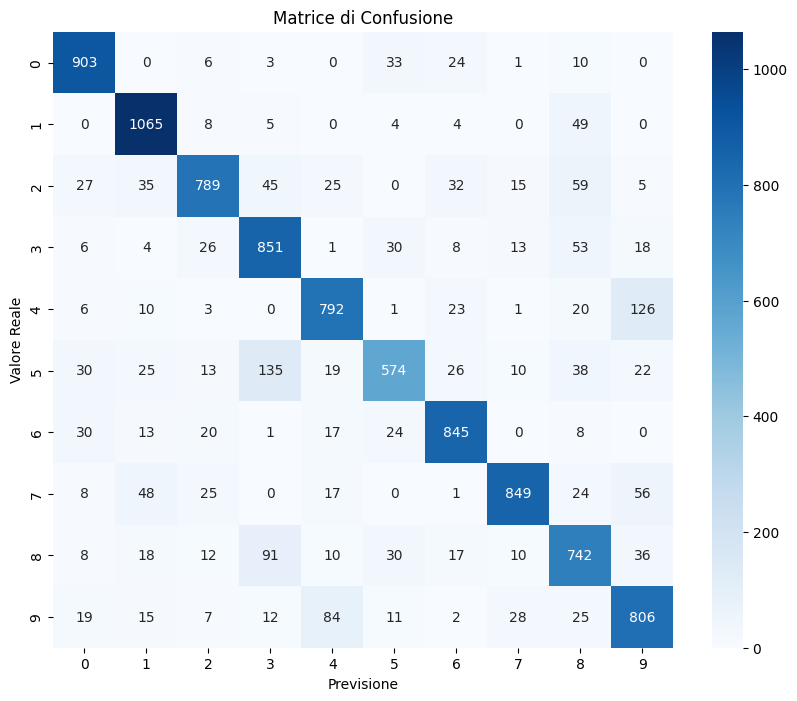

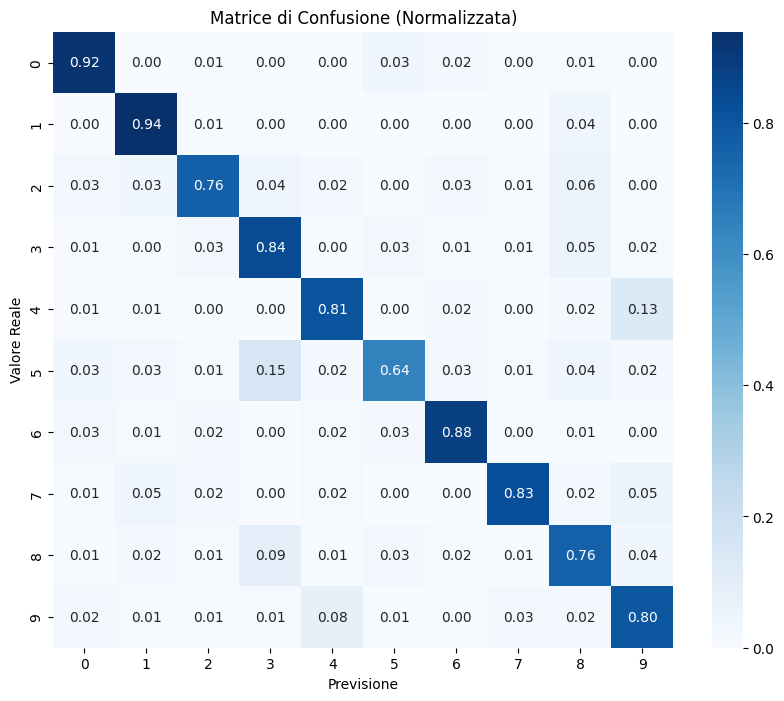


Analisi delle confusioni più frequenti:
Cifra 0 confusa più frequentemente con 5 (3.4% delle volte)
Cifra 1 confusa più frequentemente con 8 (4.3% delle volte)
Cifra 2 confusa più frequentemente con 8 (5.7% delle volte)
Cifra 3 confusa più frequentemente con 8 (5.2% delle volte)
Cifra 4 confusa più frequentemente con 9 (12.8% delle volte)
Cifra 5 confusa più frequentemente con 3 (15.1% delle volte)
Cifra 6 confusa più frequentemente con 0 (3.1% delle volte)
Cifra 7 confusa più frequentemente con 9 (5.4% delle volte)
Cifra 8 confusa più frequentemente con 3 (9.3% delle volte)
Cifra 9 confusa più frequentemente con 4 (8.3% delle volte)

Cifre ordinate dalla più difficile alla più facile da classificare:
Cifra 5: accuratezza 0.6435 (64.3%)
Cifra 8: accuratezza 0.7618 (76.2%)
Cifra 2: accuratezza 0.7645 (76.5%)
Cifra 9: accuratezza 0.7988 (79.9%)
Cifra 4: accuratezza 0.8065 (80.7%)
Cifra 7: accuratezza 0.8259 (82.6%)
Cifra 3: accuratezza 0.8426 (84.3%)
Cifra 6: accuratezza 0.8820 (88.2%)


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

conf_matrix = confusion_matrix(y_test, predizioni)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Previsione')
plt.ylabel('Valore Reale')
plt.title('Matrice di Confusione')
plt.show()

# Calcolo delle percentuali di confusione
# Normalizzazione per riga (per ogni cifra reale, dove vanno le previsioni)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Previsione')
plt.ylabel('Valore Reale')
plt.title('Matrice di Confusione (Normalizzata)')
plt.show()

# Analisi delle confusioni più frequenti
print("\nAnalisi delle confusioni più frequenti:")
for i in range(10):
    # Escludiamo la diagonale principale (predizioni corrette)
    mask = np.ones(10, dtype=bool)
    mask[i] = False
    confuso_con = np.argmax(conf_matrix[i, mask])
    # Aggiusta l'indice se necessario
    if confuso_con >= i:
        confuso_con += 1
    perc_confusione = conf_matrix[i, confuso_con] / conf_matrix[i, :].sum() * 100
    print(f"Cifra {i} confusa più frequentemente con {confuso_con} ({perc_confusione:.1f}% delle volte)")

# Calcolo delle cifre più difficili da classificare
accuratezza_per_cifra = np.diag(conf_matrix) / conf_matrix.sum(axis=1)
cifre_ordinate = np.argsort(accuratezza_per_cifra)

print("\nCifre ordinate dalla più difficile alla più facile da classificare:")
for cifra in cifre_ordinate:
    print(f"Cifra {cifra}: accuratezza {accuratezza_per_cifra[cifra]:.4f} ({accuratezza_per_cifra[cifra]*100:.1f}%)")

# Visualizziamo alcuni esempi di errori per le confusioni più frequenti
def trova_errori(y_test, predizioni, cifra_reale, cifra_predetta, num_esempi=5):
    """Trova esempi dove cifra_reale è stata classificata erroneamente come cifra_predetta."""
    indici = np.where((y_test == cifra_reale) & (predizioni == cifra_predetta))[0]
    return indici[:num_esempi]

# Troviamo le confusioni più frequenti
confusioni = []
for i in range(10):
    for j in range(10):
        if i != j:  # Escludiamo la diagonale principale
            confusioni.append((i, j, conf_matrix[i, j]))

# Ordiniamo per frequenza
confusioni.sort(key=lambda x: x[2], reverse=True)

print("\nVisualizzazione di alcuni esempi delle confusioni più frequenti:")
for reale, predetta, conteggio in confusioni[:3]:  # Consideriamo le 3 confusioni più frequenti
    print(f"\nEsempi di cifra {reale} classificata come {predetta} (occorre {conteggio} volte):")
    indici_errori = trova_errori(y_test, predizioni, reale, predetta)
    if len(indici_errori) > 0:
        errori_imgs = [X_test[i] for i in indici_errori]
        plot_imgs_labels(errori_imgs, [f"Real: {reale}, Pred: {predetta}"] * len(errori_imgs), 
                        rows=1, cols=min(5, len(errori_imgs)))